<a href="https://colab.research.google.com/github/olevelychko/labs-Data-Analysis-2023/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras, nn
from tensorflow.python.keras.backend import expand_dims
import tensorflow_datasets as tfds
import re
import string
import zipfile
import os
import cv2 as cv
from google.colab.patches import cv2_imshow
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Part 1) Fully connected feed-forward network

In [33]:
df=pd.read_csv('/content/sample_data/bmi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  400 non-null    object
 1   Height  400 non-null    int64 
 2   Weight  400 non-null    int64 
 3   Index   400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.6+ KB


In [34]:
x = df[['Height', 'Weight']]
y = np.array(df[['Index']])

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=20)
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [36]:
modelKeras = keras.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(x_train.shape[-1], )),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation="softmax"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="softmax"),
    ])

In [37]:
modelKeras.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               768       
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34817 (136.00 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 512 (2.00 KB)
________________

In [38]:
modelKeras.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])
modelKeras.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=128)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 2s 173ms/step - loss: 0.0000e+00 - accuracy: 0.0429 - val_loss: 0.0000e+00 - val_accuracy: 0.0500
Epoch 2/15
3/3 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 0.0429 - val_loss: 0.0000e+00 - val_accuracy: 0.0500
Epoch 3/15
3/3 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 0.0429 - val_loss: 0.0000e+00 - val_accuracy: 0.0500
Epoch 4/15
3/3 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 0.0429 - val_loss: 0.0000e+00 - val_accuracy: 0.0500
Epoch 5/15
3/3 [==============================] - 0s 35ms/step - loss: 0.0000e+00 - accuracy: 0.0429 - val_loss: 0.0000e+00 - val_accuracy: 0.0500
Epoch 6/15
3/3 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 0.0429 - val_loss: 0.0000e+00 - val_accuracy: 0.0500
Epoch 7/15
3/3 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 0.0429 - val_loss: 0.0000e+00 - va

In [39]:
score = modelKeras.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.05000000074505806


Part 2) Convolutional network

In [40]:
zip_ref = zipfile.ZipFile('/content/sample_data/Villains.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/sample_data') #Extracts the files into the /tmp folder
zip_ref.close()

In [41]:
num_skipped = 0
for folder_name in ("Thanos", "Venom", "Darth Vader", "Green Goblin", "Joker"):
    folder_path = os.path.join("/content/sample_data/Villains", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


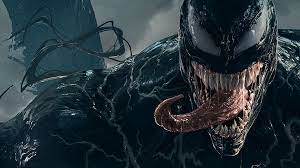

In [42]:
data = "/content/sample_data/Villains"
Ven1 = cv.imread('/content/sample_data/Villains/Venom/Venom 1.jpg')
cv2_imshow(Ven1)

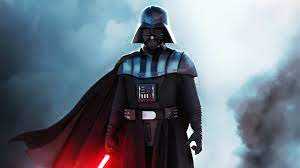

In [43]:
DV1 = cv.imread('/content/sample_data/Villains/Darth Vader/Vader 1.jpg')
cv2_imshow(DV1)

In [44]:
image_size = (180, 180)
batch_size = 128
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/sample_data/Villains",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 100 files belonging to 5 classes.
Using 80 files for training.
Using 20 files for validation.


In [45]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ])

In [46]:
AUTOTUNE = tf.data.AUTOTUNE
train = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
modelImage = keras.Sequential([
  data_augmentation,
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2D(128, 3, strides=2, padding='same', activation='tanh'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.3),
  keras.layers.Conv2D(256, 3, strides=2, padding='same', activation='tanh'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation='softmax'),
  keras.layers.Dense(1, name="outputs")
])

In [55]:
modelImage.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])
modelImage.fit(train, validation_data = val, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 4s 4s/step - loss: 2.2650e-07 - accuracy: 0.2125 - val_loss: 2.8610e-07 - val_accuracy: 0.1500
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.2650e-07 - accuracy: 0.2125 - val_loss: 2.8610e-07 - val_accuracy: 0.1500
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2.2650e-07 - accuracy: 0.2125 - val_loss: 2.8610e-07 - val_accuracy: 0.1500
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2.2650e-07 - accuracy: 0.2125 - val_loss: 2.8610e-07 - val_accuracy: 0.1500
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 2.2650e-07 - accuracy: 0.2125 - val_loss: 2.8610e-07 - val_accuracy: 0.1500
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 2.2650e-07 - accuracy: 0.2125 - val_loss: 2.8610e-07 - val_accuracy: 0.1500
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 2.2650e-07 - accuracy: 0.2125 - val_loss: 2.8610e-07 - val_accuracy: 0.1

In [49]:
score = modelImage.evaluate(val, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.15000000596046448


1/1 [==============================] - 0s 129ms/step
tf.Tensor([1.], shape=(1,), dtype=float32)


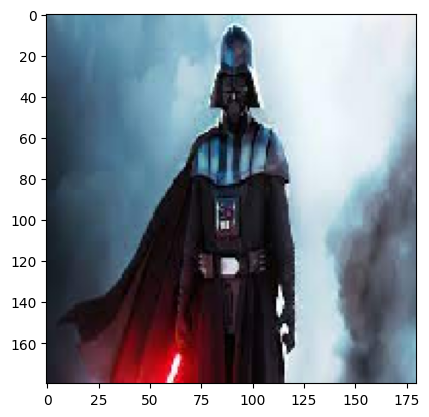

In [50]:
image_size = (180, 180)
image = tf.keras.preprocessing.image.load_img( "/content/sample_data/Villains/Darth Vader/Vader 1.jpg", target_size=image_size)
plt.imshow(image)

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])

input_arr = input_arr.astype('float32') / 255.

predictions = modelImage.predict(input_arr)
score = tf.nn.softmax(predictions[0])
print(score)

Part 3) Recurrent networks

In [51]:
df1 = pd.read_csv('/content/sample_data/science.csv')
df1.columns

Index(['Id', 'Comment', 'Topic'], dtype='object')

In [52]:
x_train, x_test, y_train, y_test = train_test_split(df1['Comment'], df1['Topic'], test_size=0.20)
Counter(df1['Topic'])

Counter({'Biology': 3591, 'Physics': 2184, 'Chemistry': 2920})

Cast String to Float

In [56]:
for i in range(len(y_train)):
  y_test[y_test=='Biology']=1
  y_test[y_test=='Physics']=2
  y_test[y_test=='Chemistry']=3
  y_train[y_train=='Biology']=1
  y_train[y_train=='Physics']=2
  y_train[y_train=='Chemistry']=3

In [57]:
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [58]:
vocab_size = 10000
oov_token = ""
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)
max_length = 100
padding_type = "post"
trunction_type="post"
x_train = keras.utils.pad_sequences(x_train_sequences,maxlen=max_length, padding=padding_type, truncating=trunction_type)
x_test = keras.utils.pad_sequences(x_test_sequences,maxlen=max_length, padding=padding_type, truncating=trunction_type)


In [59]:
word_index = tokenizer.word_index
total_words = len(tokenizer.word_index) + 1

In [60]:
model = Sequential()
model.add(Embedding(total_words, 32, input_length = max_length))
model.add(LSTM(64))
model.add(Dense(1, activation='softmax'))

In [61]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),  loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


55/55 [==============================] - 14s 219ms/step - loss: 0.0000e+00 - accuracy: 0.4135 - val_loss: 0.0000e+00 - val_accuracy: 0.4112
Epoch 2/10
55/55 [==============================] - 9s 165ms/step - loss: 0.0000e+00 - accuracy: 0.4135 - val_loss: 0.0000e+00 - val_accuracy: 0.4112
Epoch 3/10
55/55 [==============================] - 11s 193ms/step - loss: 0.0000e+00 - accuracy: 0.4135 - val_loss: 0.0000e+00 - val_accuracy: 0.4112
Epoch 4/10
55/55 [==============================] - 13s 234ms/step - loss: 0.0000e+00 - accuracy: 0.4135 - val_loss: 0.0000e+00 - val_accuracy: 0.4112
Epoch 5/10
55/55 [==============================] - 11s 201ms/step - loss: 0.0000e+00 - accuracy: 0.4135 - val_loss: 0.0000e+00 - val_accuracy: 0.4112
Epoch 6/10
55/55 [==============================] - 14s 252ms/step - loss: 0.0000e+00 - accuracy: 0.4135 - val_loss: 0.0000e+00 - val_accuracy: 0.4112
Epoch 7/10
55/55 [==============================] - 12s 221ms/step - loss: 0.0000e+00 - accuracy: 0.4135 -

In [62]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.4111558496952057


To conclude, classification and regression by neural networks gave lower accuracy than methods from 1st and 2-nd labs. It depends on many factors (activation function, optimizer, and learning rate). I tried to get the highest accuracy by changing these factors, but it didn`t significantly help.